# Importamos las librerias a usar

In [76]:
# !pip3 install --upgrade wandb
# !pip install scikit-learn

In [77]:
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.image import imread
import sklearn
import os
import time

In [78]:
from tensorflow import keras
from tensorflow.keras.models import Sequential
from keras import layers
from keras import initializers
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.optimizers import RMSprop, SGD, Adam
from tensorflow.keras import regularizers
from tensorflow.keras.models import load_model
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.callbacks import EarlyStopping

# Preparación

## Creamos la clase para resolver la ecuación diferencial

In [95]:
class ODEsolver(Sequential):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.loss_tracker = keras.metrics.Mean(name="loss")
        self.mse = tf.keras.losses.MeanSquaredError()

    @property
    def metrics(self):
      return [self.loss_tracker]

    def train_step(self, data):
         batch_size = tf.shape(data)[0]
         min = tf.cast(tf.reduce_min(data),tf.float32)
         max = tf.cast(tf.reduce_max(data),tf.float32)
         x = tf.random.uniform((batch_size,1), minval=min, maxval=max)

         with tf.GradientTape() as tape:
             with tf.GradientTape() as tape2:
                 tape2.watch(x)
                 y_pred = self(x, training=True)
             
             dy = tape2.gradient(y_pred, x) #derivada del modelo con respecto a entradas x
             x_o = tf.zeros((batch_size,1)) #valor de x en condicion inicial x_0=0
             y_o = self(x_o,training=True) #valor del modelo en en x_0
             eq = x*dy + y_pred - tf.cos(x)*x**2 #Ecuacion diferencial evaluada en el modelo. Queremos que sea muy pequeno
             ic = 0. #valor que queremos para la condicion inicial o el modelo en x_0
             loss = self.mse(0., eq) + self.mse(y_o,ic)

        # Apply grads
         grads = tape.gradient(loss, self.trainable_variables)
         self.optimizer.apply_gradients(zip(grads, self.trainable_variables))
        #update metrics
         self.loss_tracker.update_state(loss)
        # Return a dict mapping metric names to current value
         return {"loss": self.loss_tracker.result()}

# Creación de la red neuronal

In [96]:
model = ODEsolver()
model.add(Dense(10, activation='tanh', input_shape=(1,)))
model.add(Dense(1, activation='tanh'))
model.add(Dense(1))

## Observamos el comportamiento del loss

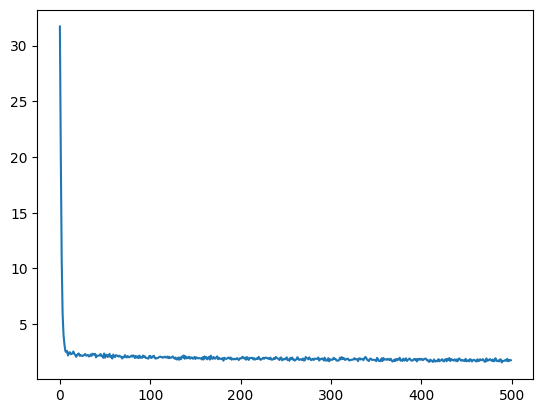

In [97]:
model.compile(optimizer=RMSprop(),metrics=['loss'])
x=tf.linspace(-5,5,10000)
history = model.fit(x,epochs=500,verbose=0)
plt.plot(history.history["loss"])

## Entrenamos el modelo y visualizamos

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 531us/step


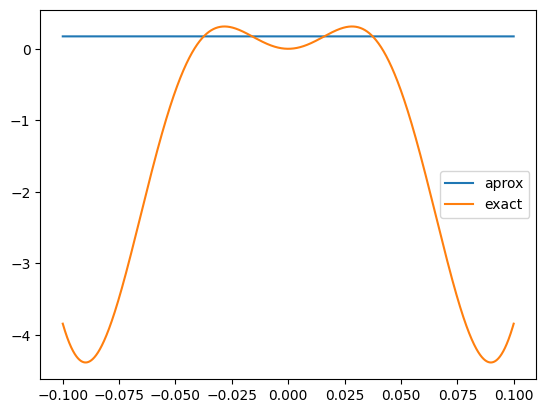

In [98]:
x_testv = tf.linspace(-0.1,0.1,10000)
a = model.predict(x_testv)
plt.plot(x_testv, a ,label = "aprox")
C=0
plt.plot(x_testv, x*np.sin(x)-(2*np.sin(x))/x+2*np.cos(x) + C/x, label = "exact")
plt.legend()
plt.show()